## to explore


15min has better correlations to daily returns
15min created with tbbo data
target consisting of moving ma components, which has a memory
by retraining the model you are learning the ma and preserving the ma memory

FEATURE DEV:
  * anchored daily vwap
  * anchored daily ma (14)
  * just ma as features
  * forward looking MA as target (https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60)
  * on MA as features/targets https://chatgpt.com/c/672d03bf-ded4-8013-8349-330786edc44f
  * https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60 
  * also SLOPE of MA or divergence(DIST), as target variable
  * maybe use imbalance columns
  * add MA on returns as additional features

figure out how to turn to signals


* enhance feature
  * try add number of trades, inbalance columns into features
  * try process use tbbo data for aggregation and use bbo data in ohlcv bars and build features upon it https://databento.com/docs/examples/basics-historical/midprice/example
  * datetime features?
* also keep idea of retreain the model frequently even intraday or find working interval (30+1)

This creates features and tests the model and output features to csv. Upon this csv prediction potential can be checked with other notebook and also cgb reg a class run.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class LibraryTradingModel:
    def __init__(self, train_days=10, test_days=1, forward_bars=5, n_classes=5):
        """
        Initialize the trading model.
        
        Parameters:
        train_days (int): Number of days for training window
        test_days (int): Number of days for testing window
        forward_bars (int): Number of bars to look ahead for returns
        n_classes (int): Number of classes to create (using percentiles)
        """
        self.train_days = train_days
        self.test_days = test_days
        self.forward_bars = forward_bars
        self.n_classes = n_classes
        self.scaler = StandardScaler()
        self.class_boundaries = None
    
    def get_date_windows(self, data):
        """
        Calculate date windows for training and testing.
        Handles any frequency of data by using datetime index.
        
        Returns:
        List of tuples: (train_start, train_end, test_start, test_end)
        """
        # Convert days to timedelta
        train_delta = timedelta(days=self.train_days)
        test_delta = timedelta(days=self.test_days)
        
        start_date = data.index[0]
        end_date = data.index[-1]
        
        windows = []
        current_start = start_date
        
        while True:
            train_end = current_start + train_delta
            test_start = train_end
            test_end = test_start + test_delta
            
            # Break if we've reached the end of data
            if test_end > end_date:
                break
                
            windows.append((current_start, train_end, test_start, test_end))
            current_start = current_start + timedelta(days=self.test_days)  # Move forward by test period
            
        return windows
    
    def prepare_features(self, df):
        """
        Enhanced feature creation including various MA-based features.
        Careful to avoid forward-looking bias in features.
        """
        features = df.copy()
        
        # Original features
        features['log_return'] = np.log(features['close'] / features['close'].shift(1))
        features['returns_1'] = features['close'].pct_change()
        features['returns_5'] = features['close'].pct_change(5)
        features['returns_20'] = features['close'].pct_change(20)
        
        # MA-based features
        ma_lengths = [5, 10, 20, 50]
        for length in ma_lengths:
            # Regular MAs
            features[f'ma_{length}'] = features['close'].rolling(length).mean()
            
            # MA slopes (rate of change)
            features[f'ma_{length}_slope'] = features[f'ma_{length}'].pct_change(3)
            
            # Price distance from MA
            features[f'price_ma_{length}_dist'] = (features['close'] - features[f'ma_{length}']) / features[f'ma_{length}']
            
            # MA crossovers
            if length > 5:
                features[f'ma_5_{length}_cross'] = (features['ma_5'] - features[f'ma_{length}']) / features[f'ma_{length}']
        
        # MA convergence/divergence
        features['ma_convergence'] = ((features['ma_5'] - features['ma_20']).abs() / 
                                    features['ma_20'].rolling(10).mean())
        
        # Volatility features using MAs
        features['ma_volatility'] = features['ma_5'].rolling(10).std() / features['ma_20']
        
        # MA momentum
        features['ma_momentum'] = (features['ma_5'] / features['ma_5'].shift(5) - 1) * 100
        
        # Drop NaN values
        features = features.dropna()
        
        return features

    def create_target(self, df, train_data=None):
        """
        Create target variable based on forward MAs and returns.
        Combines both MA crossovers and forward returns.
        """
        # Calculate forward MA (this is okay for target as it represents what we're trying to predict)
        future_ma_fast = df['close'].shift(-self.forward_bars).rolling(5).mean()
        future_ma_slow = df['close'].shift(-self.forward_bars).rolling(20).mean()
        current_ma_slow = df['close'].rolling(20).mean()
        
        # Calculate forward returns (original approach)
        forward_returns = df['close'].shift(-self.forward_bars) / df['close'] - 1
        
        # Combine signals: Consider both MA crossover and return magnitude
        ma_signal = (future_ma_fast - future_ma_slow) / current_ma_slow
        combined_signal = (ma_signal + forward_returns) / 2  # Equal weighting
        
        if train_data is None:
            # This is training data - calculate class boundaries
            signal_data = combined_signal.dropna()
            
            # Calculate percentile-based boundaries
            percentiles = np.linspace(0, 100, self.n_classes + 1)
            self.class_boundaries = np.percentile(signal_data, percentiles)
            
            # Ensure uniqueness
            self.class_boundaries = np.unique(self.class_boundaries)
            
            # Add small epsilon to avoid boundary issues
            epsilon = 1e-10
            self.class_boundaries[0] -= epsilon
            self.class_boundaries[-1] += epsilon
            
            # Print distribution info
            print("\nClass Boundaries Distribution:")
            for i in range(len(self.class_boundaries)-1):
                count = ((signal_data >= self.class_boundaries[i]) & 
                        (signal_data < self.class_boundaries[i+1])).sum()
                pct = count / len(signal_data) * 100
                print(f"Class {i}: {self.class_boundaries[i]:.8f} to {self.class_boundaries[i+1]:.8f} "
                    f"(count: {count}, {pct:.2f}%)")
        
        # Classify signals
        classes = pd.cut(combined_signal, 
                        bins=self.class_boundaries, 
                        labels=range(self.n_classes),
                        include_lowest=True)
        
        return classes

    def get_feature_columns(self):
        """
        Return list of feature columns to use in the model.
        """
        base_features = ['log_return', 'returns_1', 'returns_5', 'returns_20', 'close']
        
        ma_features = []
        ma_lengths = [5, 10, 20, 50]
        
        for length in ma_lengths:
            ma_features.extend([
                f'ma_{length}_slope',
                f'price_ma_{length}_dist'
            ])
            if length > 5:
                ma_features.append(f'ma_5_{length}_cross')
        
        additional_features = [
            'ma_convergence',
            'ma_volatility',
            'ma_momentum'
        ]
        
        return base_features + ma_features + additional_features

    def prepare_data(self, df, train_data=None):
        """
        Prepare features and target for modeling.
        """
        # Prepare features
        features_df = self.prepare_features(df)
        
        # Create target
        target = self.create_target(features_df, train_data if train_data is not None else None)
        
        # Get feature columns
        feature_cols = self.get_feature_columns()
        
        X = features_df[feature_cols]
        y = target
        
        # Scale features
        if train_data is None:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_scaled = self.scaler.transform(X)
        
        # Convert to DataFrame to keep column names
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        
        return X_scaled, y
    
    def display_confusion_matrix(self, y_true, y_pred, title):
        """
        Display confusion matrix with detailed information.
        """
        cm = confusion_matrix(y_true, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        labels = [[f'{int(cm[i, j])}\n{cm_percent[i, j]:.1f}%' 
                  if cm[i, j] > 0 else ''
                  for j in range(len(cm))]
                 for i in range(len(cm))]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
        plt.title(f'Confusion Matrix: {title}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print additional metrics
        print("\nPer-class metrics:")
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        metrics_df = pd.DataFrame({
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }, index=[f'Class {i}' for i in range(self.n_classes)])
        
        print(metrics_df.round(3))
        print(f"\nOverall Accuracy: {np.sum(np.diag(cm)) / np.sum(cm):.3f}")

    def run_iteration(self, train_data, test_data, iteration_num):
        """
        Run a single iteration of training and testing.
        Enhanced error handling and class validation.
        """
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        
        try:
            # Reset class boundaries for each iteration
            self.class_boundaries = None
            
            print(f"\nProcessing iteration {iteration_num}")
            print(f"Training data: {train_data.index[0]} to {train_data.index[-1]}")
            print(f"Test data: {test_data.index[0]} to {test_data.index[-1]}")
            
            # Prepare training data
            X_train, y_train = self.prepare_data(train_data)
            mask_train = ~y_train.isna()
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
            
            if len(X_train) < self.forward_bars + 1:
                print(f"Warning: Iteration {iteration_num} - Insufficient training data")
                return None, None
                
            print(f"Training samples after preparation: {len(X_train)}")
            
            # Validate class distribution
            class_dist = y_train.value_counts(normalize=True).sort_index()
            print(f"Class distribution in training:")
            print(class_dist)
            
            # Check if we have all classes
            missing_classes = set(range(self.n_classes)) - set(class_dist.index)
            if missing_classes:
                print(f"\nWARNING: Missing classes in training data: {missing_classes}")
                print("Adjusting model to handle missing classes...")
                # Add one sample for each missing class to ensure model can handle all classes
                for missing_class in missing_classes:
                    X_train = pd.concat([X_train, X_train.iloc[[0]]])
                    y_train = pd.concat([y_train, pd.Series([missing_class], index=[X_train.index[-1]])])
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Prepare test data
            X_test, y_test = self.prepare_data(test_data, train_data)
            
            # Make predictions
            predictions = model.predict(X_test)
            probabilities = model.predict_proba(X_test)
            
            # Validate probabilities shape
            if probabilities.shape[1] != self.n_classes:
                raise ValueError(f"Probability matrix has wrong shape: {probabilities.shape}")
            
            # Create results DataFrame
            results = pd.DataFrame({
                'predicted_class': predictions,
                'actual_class': y_test
            }, index=X_test.index)
            
            # Add probability for each class
            for i in range(self.n_classes):
                results[f'prob_class_{i}'] = probabilities[:, i]
            
            # Display iteration results
            mask = ~results['actual_class'].isna()
            if mask.any():
                print(f"\nValid test samples: {mask.sum()}")
                self.display_confusion_matrix(
                    results.loc[mask, 'actual_class'],
                    results.loc[mask, 'predicted_class'],
                    f'Iteration {iteration_num}'
                )

            
            return results, model
            
        except Exception as e:
            print(f"Error in iteration {iteration_num}: {str(e)}")
            print(f"Training data shape: {train_data.shape}")
            print(f"Test data shape: {test_data.shape}")
            return None, None

    def run_rolling_window(self, data, num_iterations=None):
        """
        Run the model using a rolling window approach.
        Handles any frequency of data using datetime index.
        """
        # Get all possible windows
        windows = self.get_date_windows(data)
        
        if num_iterations is not None:
            windows = windows[:num_iterations]
        
        all_results = {}
        all_predictions = []
        all_actuals = []
        
        for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
            # Get data for this iteration using datetime indexing
            train_mask = (data.index >= train_start) & (data.index < train_end)
            test_mask = (data.index >= test_start) & (data.index < test_end)
            
            train_data = data[train_mask]
            test_data = data[test_mask]
            
            # Skip if not enough data
            min_required_bars = max(20, self.forward_bars + 1)  # minimum bars needed for features
            if len(train_data) < min_required_bars or len(test_data) < 1:
                print(f"Skipping iteration {i}: Insufficient data (train: {len(train_data)}, test: {len(test_data)} bars)")
                continue
            
            results, model = self.run_iteration(train_data, test_data, i)
            
            if results is not None:
                all_results[i] = {
                    'train_period': (train_start, train_end),
                    'test_period': (test_start, test_end),
                    'results': results,
                    'model': model
                }
                
                mask = ~results['actual_class'].isna()
                if mask.any():
                    all_predictions.extend(results.loc[mask, 'predicted_class'])
                    all_actuals.extend(results.loc[mask, 'actual_class'])
        
        # Display overall results
        if all_predictions:
            print("\n=== Overall Results Across All Iterations ===")
            self.display_confusion_matrix(
                all_actuals,
                all_predictions,
                'All Iterations Combined'
            )
        elif not all_results:
            print("No valid results generated across all iterations.")

        return all_results

    def generate_features_csv(self, data, output_filename, use_raw_target=True, 
                            include_target_components=False, use_generic_features=False):
        """
        Generate features and target variables with configurable output format.
        
        Parameters:
        data (pd.DataFrame): Input data with required columns
        output_filename (str): Name of the output CSV file
        use_raw_target (bool): If True, use raw combined signal as target instead of classes
        include_target_components (bool): If True, include all target components in output
        use_generic_features (bool): If True, name features as feature_0 to feature_N
        """
        try:
            print("Preparing features for entire dataset...")
            
            # Prepare features
            features_df = self.prepare_features(data)
            
            # Calculate target components
            future_ma_fast = features_df['close'].shift(-self.forward_bars).rolling(5).mean()
            future_ma_slow = features_df['close'].shift(-self.forward_bars).rolling(20).mean()
            current_ma_slow = features_df['close'].rolling(20).mean()
            
            # Calculate forward returns
            forward_returns = features_df['close'].shift(-self.forward_bars) / features_df['close'] - 1
            
            # Calculate MA signal
            ma_signal = (future_ma_fast - future_ma_slow) / current_ma_slow
            
            # Combined signal (used for classification)
            combined_signal = (ma_signal + forward_returns) / 2
            
            # If using classified target, create classes
            if not use_raw_target:
                self.class_boundaries = None  # Reset class boundaries
                target = self.create_target(features_df)
            else:
                target = combined_signal  # Use raw combined signal
            
            # Get all feature columns
            feature_cols = self.get_feature_columns()
            
            # Get raw features (no scaling)
            X = features_df[feature_cols]
            
            # Create output DataFrame based on format preference
            if use_generic_features:
                # Generic feature names
                output_df = pd.DataFrame(X.values, 
                                        columns=[f'feature_{i}' for i in range(len(feature_cols))],
                                        index=X.index)
                
                # # Add timestamp if present
                # output_df['Open time'] = X.index
                
                # Add only main target
                output_df['target'] = target
                
                if include_target_components:
                    output_df['forward_return'] = forward_returns
                    output_df['ma_signal'] = ma_signal
                    output_df['combined_signal'] = combined_signal
                    
            else:
                # Original descriptive names
                output_df = pd.DataFrame(index=X.index)
                # output_df['Open time'] = X.index
                
                # Add features with descriptive names
                for col in feature_cols:
                    output_df[col] = features_df[col]
                
                # Add target(s)
                output_df['target'] = target
                if include_target_components:
                    output_df['forward_return'] = forward_returns
                    output_df['ma_signal'] = ma_signal
                    output_df['combined_signal'] = combined_signal
            
            # Remove rows with NaN values
            output_df = output_df.dropna()
            
            # Save to CSV
            output_df.to_csv(output_filename, index=True, index_label='Open time')
            
            # Print information about the generated features
            print(f"\nFeatures and target generated successfully!")
            print(f"Output saved to: {output_filename}")
            print(f"Total rows: {len(output_df)}")
            print(f"Total features: {len(feature_cols)}")
            print(f"Target type: {'Raw combined signal' if use_raw_target else 'Classified'}")
            
            if not use_generic_features:
                # Print feature descriptions
                print("\nFeature descriptions:")
                feature_descriptions = {
                    'log_return': 'Log return of close price',
                    'return_1d': '1-day price return',
                    'return_5d': '5-day price return',
                    'return_20d': '20-day price return',
                    'ma_convergence': 'Convergence/divergence of fast and slow MAs',
                    'ma_volatility': 'Volatility based on MA movement',
                    'ma_momentum': 'Momentum of fast MA'
                }
                
                ma_lengths = [5, 10, 20, 50]
                for length in ma_lengths:
                    feature_descriptions.update({
                        f'ma_{length}': f'{length}-period Moving Average',
                        f'ma_{length}_slope': f'Slope of {length}-period MA',
                        f'price_ma_{length}_dist': f'Price distance from {length}-period MA'
                    })
                    if length > 5:
                        feature_descriptions[f'ma_5_{length}_cross'] = f'Crossover between 5 and {length}-period MAs'
                
                for feat, desc in feature_descriptions.items():
                    if feat in feature_cols:
                        print(f"{feat}: {desc}")
            else:
                # Print generic feature mapping
                print("\nFeature mapping:")
                for i, original_name in enumerate(feature_cols):
                    print(f"feature_{i}: {original_name}")
            
            # Print target information
            print("\nTarget variables included:")
            print("- target: Final target (either classified or raw combined signal)")
            if include_target_components:
                print("- forward_return: Raw forward return")
                print("- ma_signal: Moving average crossover signal")
                print("- combined_signal: Combined MA and return signal")
            
            # Print basic statistics
            print("\nFeature statistics:")
            stats_df = X.describe()
            print(stats_df)
            
            return output_df
            
        except Exception as e:
            print(f"Error generating features: {str(e)}")
            raise

In [19]:
import vectorbtpro as vbt
import ttools as tts
#from lightweight_charts import chart, Panel, PlotDFAccessor, PlotSRAccessor
#import talib
import ttools as tts
from ttools.config import DATA_DIR
from ttools.utils import zoneNY, AggType
from ttools.loaders import load_data
from numba import jit
import pandas as pd
import numpy as np
from datetime import datetime
vbt.settings.plotting.auto_rangebreaks = True
vbt.settings.set_theme("dark")
vbt.settings.plotting["use_resampler"] = True

In [23]:
#This is how to call LOAD function
symbol = ["BAC"]
#datetime in zoneNY 
day_start = datetime(2024, 7, 1, 9, 30, 0)
day_stop = datetime(2024, 10, 20, 16, 0, 0)
day_start = zoneNY.localize(day_start)
day_stop = zoneNY.localize(day_stop)

#requested AGG
resolution = 12 #10min bars #12s bars
agg_type = AggType.OHLCV #other types AggType.OHLCV_VOL, AggType.OHLCV_DOL, AggType.OHLCV_RENKO
exclude_conditions = ['C','O','4','B','7','V','P','W','U','Z','F','9','M','6'] #None to defaults
minsize = 100 #min trade size to include
main_session_only = False
force_remote = False

bac_data = load_data(symbol = symbol,
                     agg_type = agg_type,
                     resolution = resolution,
                     start_date = day_start,
                     end_date = day_stop,
                     #exclude_conditions = None,
                     minsize = minsize,
                     main_session_only = main_session_only,
                     force_remote = force_remote,
                     return_vbt = False, #returns vbt object
                     verbose = True
                     )

matched agg files 0
BAC Contains 78  market days
BAC All 78 split files loaded in 14.669965982437134 seconds
Trimming 2024-07-01 09:30:00-04:00 2024-10-20 16:00:00-04:00
excluding ['4', '6', '7', '9', 'B', 'C', 'F', 'M', 'O', 'P', 'U', 'V', 'W', 'Z']
exclude done
minsize 100
minsize done
BAC filtered
BAC Saved to agg_cache /Users/davidbrazda/Library/Application Support/v2realbot/aggcache/BAC-AggType.OHLCV-12-2024-07-01T09-30-00-2024-10-20T16-00-00-4679BCFMOPUVWZ-100-False.parquet


Claude https://claude.ai/chat/69fbfe22-bc7f-4795-b964-15d10fbfca60

This will generate features and test them (xgbclassifier, with pct class transformation and output as directional confusion matrix)

Preparing features for entire dataset...

Features and target generated successfully!
Output saved to: features_ma_bac_12s_v2.csv
Total rows: 150586
Total features: 19
Target type: Raw combined signal

Feature descriptions:
log_return: Log return of close price
ma_convergence: Convergence/divergence of fast and slow MAs
ma_volatility: Volatility based on MA movement
ma_momentum: Momentum of fast MA
ma_5_slope: Slope of 5-period MA
price_ma_5_dist: Price distance from 5-period MA
ma_10_slope: Slope of 10-period MA
price_ma_10_dist: Price distance from 10-period MA
ma_5_10_cross: Crossover between 5 and 10-period MAs
ma_20_slope: Slope of 20-period MA
price_ma_20_dist: Price distance from 20-period MA
ma_5_20_cross: Crossover between 5 and 20-period MAs
ma_50_slope: Slope of 50-period MA
price_ma_50_dist: Price distance from 50-period MA
ma_5_50_cross: Crossover between 5 and 50-period MAs

Target variables included:
- target: Final target (either classified or raw combined signal)

Feat

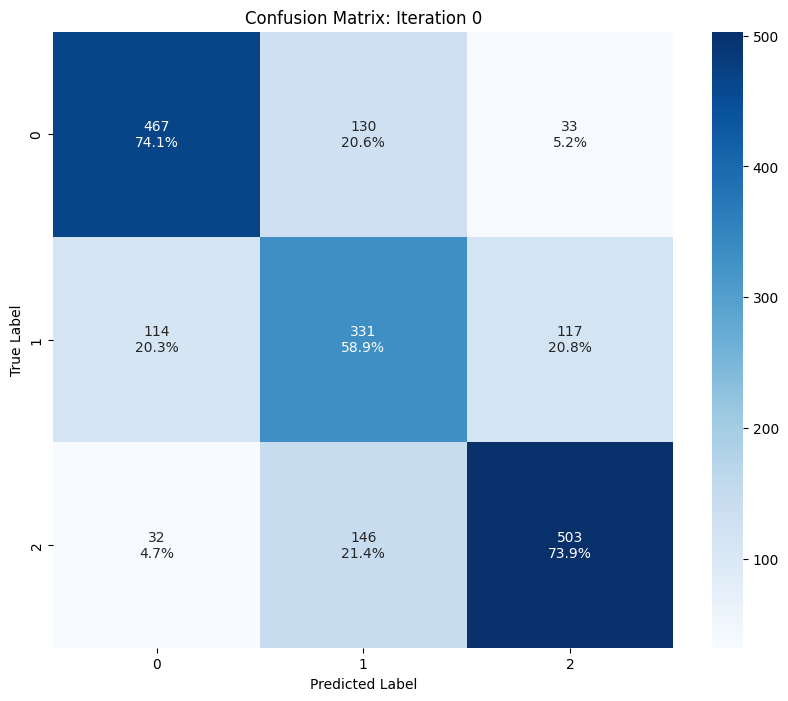


Per-class metrics:
         Precision  Recall  F1-Score
Class 0      0.762   0.741     0.751
Class 1      0.545   0.589     0.566
Class 2      0.770   0.739     0.754

Overall Accuracy: 0.695

Processing iteration 1
Training data: 2024-07-02 09:30:00-04:00 to 2024-07-11 16:00:00-04:00
Test data: 2024-07-12 09:30:00-04:00 to 2024-07-12 16:00:00-04:00

Class Boundaries Distribution:
Class 0: -0.00146144 to -0.00007487 (count: 4235, 33.34%)
Class 1: -0.00007487 to 0.00008865 (count: 4234, 33.33%)
Class 2: 0.00008865 to 0.00381099 (count: 4235, 33.34%)
Training samples after preparation: 12704
Class distribution in training:
close
0    0.333360
1    0.333281
2    0.333360
Name: proportion, dtype: float64

Valid test samples: 1871


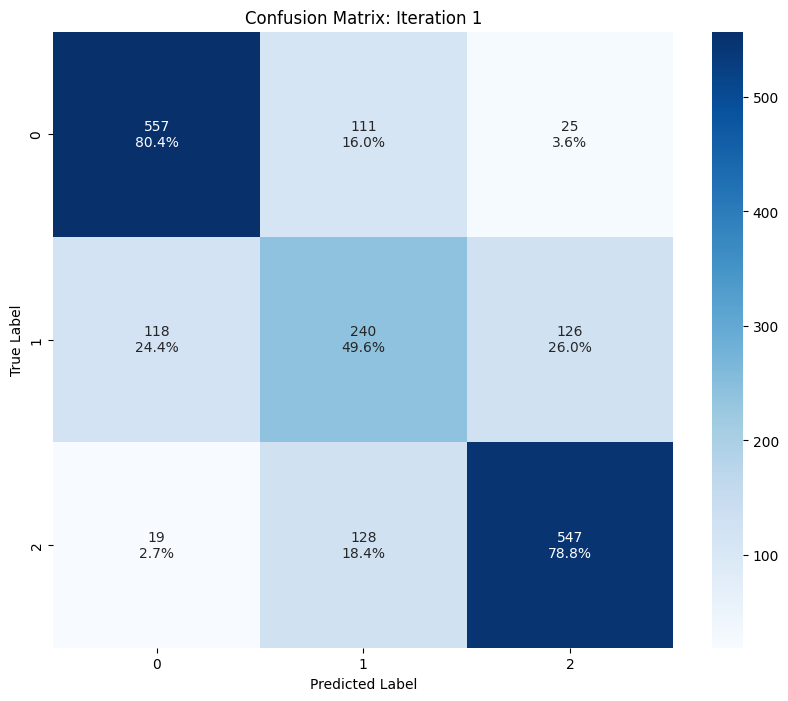


Per-class metrics:
         Precision  Recall  F1-Score
Class 0      0.803   0.804     0.803
Class 1      0.501   0.496     0.498
Class 2      0.784   0.788     0.786

Overall Accuracy: 0.718
Skipping iteration 2: Insufficient data (train: 12781, test: 0 bars)

=== Overall Results Across All Iterations ===


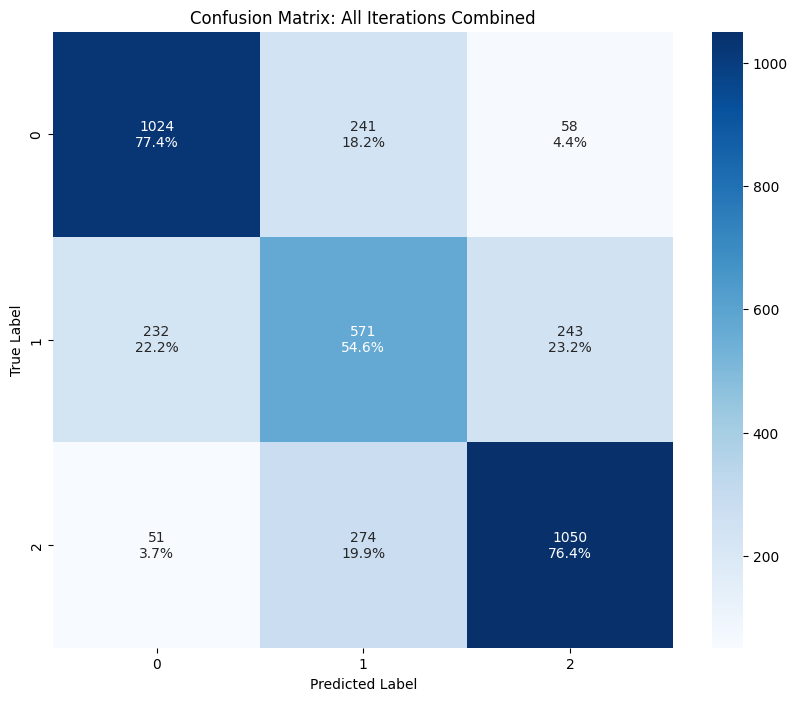


Per-class metrics:
         Precision  Recall  F1-Score
Class 0      0.783   0.774     0.779
Class 1      0.526   0.546     0.536
Class 2      0.777   0.764     0.770

Overall Accuracy: 0.706


In [24]:
CSV_FILE_PATH = "features_ma_bac_12s_v2.csv"
df = bac_data["BAC"].between_time("9:30", "16:00").copy()

model = LibraryTradingModel(train_days=10, test_days=1, forward_bars=1, n_classes=3)

features_df = model.generate_features_csv(df,
                                          CSV_FILE_PATH,
                                          use_raw_target=True,
                                          include_target_components=False, #include all target components (signal crossover etc.) vs only target
                                          use_generic_features=False) #label genericly feature_0 or descriptive ma_50   
                                          #include_ohlcv=True)  #what columns to include from input dataset                                   
                                        
results = model.run_rolling_window(df, num_iterations=3)



In [22]:
features_df.info()
#show rows containing nans
#features_df[features_df.isna().any(axis=1)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2024-07-03 10:36:00-04:00 to 2024-10-18 15:48:00-04:00
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   log_return        2501 non-null   float64
 1   returns_1         2501 non-null   float64
 2   returns_5         2501 non-null   float64
 3   returns_20        2501 non-null   float64
 4   close             2501 non-null   float64
 5   ma_5_slope        2501 non-null   float64
 6   price_ma_5_dist   2501 non-null   float64
 7   ma_10_slope       2501 non-null   float64
 8   price_ma_10_dist  2501 non-null   float64
 9   ma_5_10_cross     2501 non-null   float64
 10  ma_20_slope       2501 non-null   float64
 11  price_ma_20_dist  2501 non-null   float64
 12  ma_5_20_cross     2501 non-null   float64
 13  ma_50_slope       2501 non-null   float64
 14  price_ma_50_dist  2501 non-null   float64
 15  ma_5_50_cross     2501 non-null   float64